# Classic ML with hand engineered image features
 
This notebook uses the classical machine learninng algorithms to explain how features can be extracted from the images and used for a simple learning task with the data generated by Xiaogang.(https://ami2022group4.slack.com/archives/C03LKBAAJKW/p1656146461494769)

In [1]:
import json
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import random

from PIL import Image
from pathlib import Path


## I. Preparing the Data
The data is provided in the location /notebooks/resources, from where we can extract it to our local /notebooks/transfer_learning/resources folder. Once we have done that, we can split the image by category and extract them into a test and training set. 

In [2]:
# set seed
np.random.seed(seed=0)

In [3]:
image_path = Path("../../data", "sort")

In [4]:
# get class folders
categories = os.listdir(image_path)

image_size = 80

images = []
annotations = []

labels_folder = os.listdir(image_path)


# Stolen and modified from https://medium.com/mlearning-ai/computer-vision-exploring-your-image-datasets-the-right-way-538c5ae8ca5d

image_shapes_df = pd.DataFrame(columns=["class", "width", "height"])
raw_images = dict(zip(categories, [dict(), dict(), dict(), dict()]))   # These images are directly read from the repository, without any resizing what so ever

image_counter = 0

# iterate over all classes 
for label in labels_folder:
    
    data_dir = Path(image_path) / label
    
    for file in data_dir.glob('*.png'):
    
        image = tf.keras.preprocessing.image.load_img(file, target_size=None)
        
        image = tf.keras.preprocessing.image.img_to_array(image) / 255.
        
        height, width, _ = image.shape
        
        raw_images[label][str(image_counter)] = image
        
        image_shapes_df.loc[str(image_counter)] = (label, width, height)
        
        images.append(image)
        annotations.append(label)
        image_counter += 1

In [5]:
# Inspect dataset distribution

print(f"Count of categories: {len(categories)}")
print(f'Categories: {categories}')
print(f"Count of images: {len(images)}")
print(f"Count of annotations: {len(annotations)}")

Count of categories: 4
Categories: ['dent', 'other', 'rim', 'scratch']
Count of images: 897
Count of annotations: 897


<BarContainer object of 4 artists>

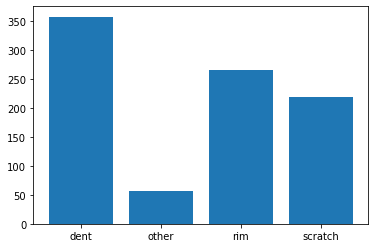

In [6]:
classes, class_total = np.unique(annotations, return_counts=True)

plt.bar(classes, class_total, align="center")

## II. Extracting the Dataset

Next we move the images to new folders, sorted by and named after their annotated categories. This allows us to extract them using the tensorflow image_dataset_from_directory function, which saves us a lot of code and trouble. We want to manipulate the image in as numpy arrays however, since this facilitates handling them during the course of this notebook.

### Size Distributions

The tensorflow image dataset function resize the images to the predefined shape, so that they can fit into our network. As a matter of fact, we know that our original images come in all sorts of shape, where the proportions of both edges can strongly deviate. Lets have a look at distribution of shape across image classes.

In [7]:
image_shapes_df = pd.DataFrame(columns=["class", "width", "height"])
raw_images = dict(zip(categories, [dict(), dict(), dict(), dict()]))   # These images are directly read from the repository, without any resizing what so ever


for label in labels_folder:
    
    folder = Path(image_path) / label

    for path in folder.iterdir():
        image = cv2.imread(str(path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        raw_images[path.parent.name][path.stem] = image
        (width, height) = image.shape[1], image.shape[0]
        image_shapes_df.loc[path.stem] = (path.parent.name, width, height)


## Create "bag of words" for images

The general idea of bag of visual words (BOVW) is to represent an image as a set of features. Features consists of keypoints and descriptors. Keypoints are the “stand out” points in an image, so no matter the image is rotated, shrink, or expand, its keypoints will always be the same. And descriptor is the description of the keypoint.

https://towardsdatascience.com/bag-of-visual-words-in-a-nutshell-9ceea97ce0fb

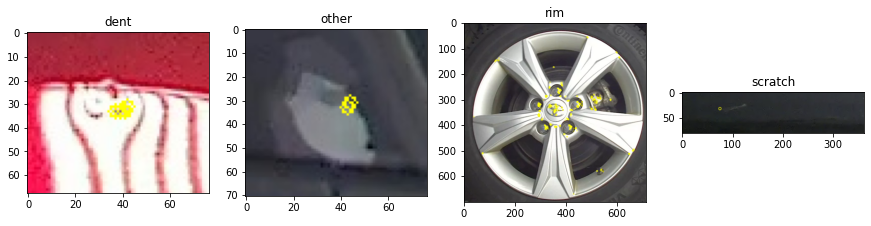

In [8]:
sample_dict = {"dent": "504613", "scratch": "503994", "rim": "504007", "other": "504106"}

def draw_keypoints(image, keypoints, color = (255, 255, 0)):
    
    # function for drawing detected keypoints into images
    for kp in keypoints:
            
        x, y = kp.pt
        plt.imshow(cv2.circle(image, (int(x), int(y)), 3, color))        

fig, ax = plt.subplots(1, 4, figsize=(15, 4))
            
for j, key in enumerate(raw_images.keys()):
    
    plt.subplot(1, 4, j+1)
    plt.title(key)
    
    # get instance of orb detector
    orb = cv2.ORB_create()

    image = raw_images[key][sample_dict[key]]
    
    kp = orb.detect(image, None)
    kp, des = orb.compute(image, kp)
    draw_keypoints(image, kp)
    
# plt.savefig(f"images.pdf")  

In [9]:
from tqdm import tqdm

des_list = []
class_counts = dict(zip(raw_images.keys(), np.zeros(4)))


for class_name, class_dict in raw_images.items():
    
    for image_id, image in tqdm(class_dict.items()):
        
        orb=cv2.ORB_create()
        
        kp=orb.detect(image,None)
    
        keypoints, descriptor= orb.compute(image, kp)
        
        if descriptor is None:
            class_counts[class_name] += 1
        
        des_list.append((image_id, descriptor))

100%|███████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 960.47it/s]


### Split into train and test set

In [10]:
train_size = int(0.7 * len(des_list))

train_idx = np.random.choice(np.arange(len(des_list)), size=train_size, replace=False)
test_idx = np.delete(np.arange(len(des_list)), train_idx)

In [11]:
# fetch descriptors
descriptors = [des_list[i][1] for i in train_idx]

# remove none Values
descriptors = [i for i in descriptors if i is not None]

descriptors = np.vstack(descriptors).astype(float)

#### Cluster features

Subsequently, the previously found features are clustered and assigned to a "vocabulary" using kmeans clustering.

In [12]:
from scipy.cluster.vq import kmeans,vq
from sklearn.cluster import DBSCAN

number_of_clusters=5

def get_clusters(descriptors, des_list, k=4):

    # calculate "vocabulary" and variance of clusters
    voc, variance = kmeans(descriptors, k, 1)
    
    # create dicts for features
    description_dict = { key: value for key, value in des_list }
    orb_features = {key: np.zeros(k, dtype=np.float32) for key in description_dict.keys()}

    # iterate over classes
    for class_name, class_dict in raw_images.items():

        # iterate over all images
        for image_id, image in tqdm(class_dict.items()):

            description_dict[image_id]

            if description_dict[image_id] is None:
                orb_features[image_id] = np.array([np.nan] * k)
                continue

            words, distance = vq(description_dict[image_id], voc)

            for w in words:

                orb_features[image_id][w] += 1


    return orb_features

orb_features = get_clusters(descriptors, des_list, k=number_of_clusters)

100%|██████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 3530.90it/s]


In [13]:
image_dataframe = pd.DataFrame(columns=["class", "aspect_ratio", "area", 
                                        "r_channel_mean", "g_channel_mean", "b_channel_mean",
                                        "r_channel_std", "g_channel_std", "b_channel_std",
                                        "r_channel_per", "g_channel_per", "b_channel_per",
                                        "blurriness"] + [ "orb_" + str(n) for n in range(number_of_clusters)])

In [14]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

n_sample = 1000
n_clusters = 3

kmeans_model = KMeans(n_clusters=3)
cluster = kmeans_model.fit_predict(descriptors[:n_sample])

In [15]:
tsne = TSNE(perplexity=50, learning_rate="auto")
reduced_representation = tsne.fit_transform(np.concatenate([descriptors[:n_sample], kmeans_model.cluster_centers_], axis=0))

C:\Users\linya\anaconda3\envs\linyanIPenv\envs\linyanIPenv\envs\linyanRLenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [16]:
sns.set_theme()

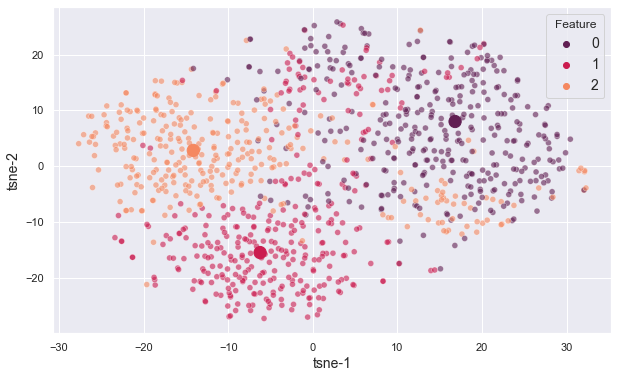

In [17]:
df_tsne = pd.DataFrame({"Feature": np.append(cluster, np.arange(3)), "tsne-1": reduced_representation[:,0], "tsne-2": reduced_representation[:,1]})
df_tsne["Size"] = 1
df_tsne.loc[1000:, "Size"] = 4

plt.figure(figsize=(10,6))
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    

sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue="Feature",
    palette=sns.color_palette("rocket", 3),   
    data=df_tsne,
    legend="full",
    alpha=0.6
)

plt.scatter(x=reduced_representation[n_sample:,0], y=reduced_representation[n_sample:,1], s=150,  c=sns.color_palette("rocket", 3))

plt.savefig('BagOfWordsCluster.pdf')  

## Create Dataset

In [18]:
# add blurriness as column
blurriness_func = lambda x: cv2.Laplacian(x, cv2.CV_64F).var()

# iterate over classes
for class_name, class_dict in raw_images.items():
    
    # iterate over all images
    for image_id, image in tqdm(class_dict.items()):
        
        x, y, _ = image.shape
        
        aspect_ratio = x / y
        area = x * y
        
        r_channel_mean, g_channel_mean, b_channel_mean  = np.mean(image, axis=(0, 1))
        r_channel_std, g_channel_std, b_channel_std  = np.std(image, axis=(0, 1))
        r_channel_per, g_channel_per, b_channel_per = np.percentile(image, 10, axis=(0, 1))
        
        blurriness = blurriness_func(image)

        image_dataframe.loc[image_id] = [class_name, aspect_ratio, area,
                                        r_channel_mean, g_channel_mean, b_channel_mean,
                                        r_channel_std, g_channel_std, b_channel_std,
                                        r_channel_per, g_channel_per, b_channel_per,
                                        blurriness] + orb_features[image_id].tolist()

100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [00:02<00:00, 99.14it/s]


In [19]:
no_orb = image_dataframe[image_dataframe["orb_0"].isnull()].index.tolist()
orb_found = image_dataframe[~image_dataframe["orb_0"].isnull()].index.tolist()

In [20]:
image_dataframe.iloc[test_idx]

,class,aspect_ratio,area,r_channel_mean,g_channel_mean,b_channel_mean,r_channel_std,g_channel_std,b_channel_std,r_channel_per,g_channel_per,b_channel_per,blurriness,orb_0,orb_1,orb_2,orb_3,orb_4
504009,dent,1.242424,1353,106.255728,105.857354,115.663710,38.209303,37.561022,37.900695,59.0,60.2,71.0,888.547111,NaN,NaN,NaN,NaN,NaN
504011,dent,1.460317,5796,99.598344,98.031401,113.123188,38.022987,45.277646,45.491158,71.0,60.0,74.0,806.578278,0.0,0.0,0.0,0.0,1.0
504038,dent,0.714286,3500,37.443429,39.514571,40.473714,7.628926,7.770167,7.874091,26.0,29.0,30.0,24.911560,NaN,NaN,NaN,NaN,NaN
504046,dent,0.139405,40350,121.369343,115.968600,124.759157,61.972529,66.465393,64.312965,58.0,47.0,51.0,2076.447201,23.0,2.0,15.0,13.0,1.0
504047,dent,0.808511,1786,143.863382,152.638858,157.366181,68.722630,66.781035,64.725099,72.0,86.0,92.0,10930.218327,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504798,scratch,0.965116,7138,49.859484,49.705099,51.441020,27.999009,29.505114,31.408140,31.0,30.0,30.0,147.066297,NaN,NaN,NaN,NaN,NaN
504828,scratch,0.797297,4366,234.566193,234.984425,228.082913,32.341464,32.401742,32.201076,179.0,178.0,175.0,308.250005,NaN,NaN,NaN,NaN,NaN
504870,scratch,0.266667,4860,166.187860,160.774691,160.895885,79.322921,81.030191,77.679530,72.0,67.0,71.0,425.178982,NaN,NaN,NaN,NaN,NaN
504871,scratch,0.309524,4914,70.915547,70.554742,68.920024,36.727622,36.299050,35.720605,31.0,31.0,29.0,134.869008,NaN,NaN,NaN,NaN,NaN


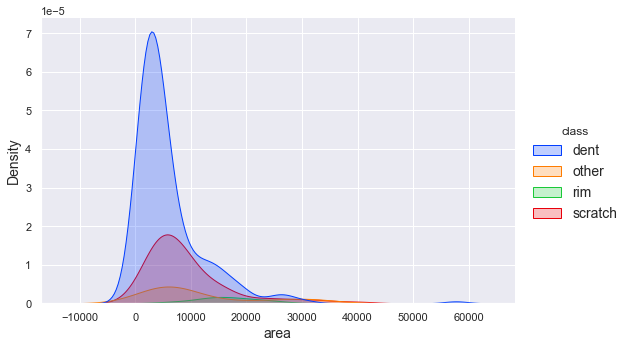

In [21]:
sns.displot(data=image_dataframe.loc[no_orb], hue="class", x="area", kind='kde', fill=True, palette=sns.color_palette('bright')[:4], height=5, aspect=1.5)

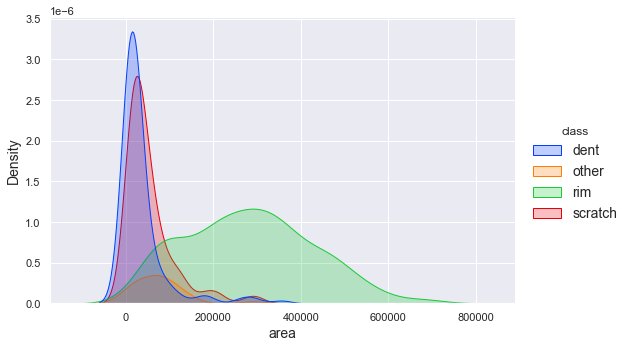

In [22]:
sns.displot(data=image_dataframe.loc[orb_found], hue="class", x="area", kind='kde', fill=True, palette=sns.color_palette('bright')[:4], height=5, aspect=1.5)

In [23]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

In [24]:
X_train = image_dataframe.drop("class", axis=1).iloc[train_idx]
X_test = image_dataframe.drop("class", axis=1).iloc[test_idx]

y_train = image_dataframe["class"].iloc[train_idx]
y_test = image_dataframe["class"].iloc[test_idx]

In [25]:
# fill nan with column mean
X_train = X_train.fillna(0.)
X_test = X_test.fillna(0.)

In [26]:
import random

@np.vectorize
def super_duper_classifier(image_size: int)-> str:
    
    if image_size < 500:
        return random.choice(["other", "dent"])
    
    elif image_size < 3e4:
        return "scratch"
    
    else:
        return "rim"

In [27]:
from sklearn.metrics import accuracy_score

y_pred = super_duper_classifier(X_test['area'].to_numpy())
print(f"The random forest classifier is able to archive {accuracy_score(y_test, y_pred)} accuracy!")

The random forest classifier is able to archive 0.4185185185185185 accuracy!


In [28]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

from time import time

gnb = ComplementNB()
rdf = RandomForestClassifier()

In [29]:
from sklearn.metrics import f1_score

def train_model(model):
    
    # train 
    start = time()
    model = model.fit(X_train, y_train)
    stop = time()
    
    train_time = stop - start
    
    # inference
    start = time()
    y_pred = model.predict(X_test)
    stop = time()
    
    inference_time = stop - start
    
    # accuracy
    accuracy = model.score(X_test, y_test)

    # F1 score
    f1 = f1_score(y_true=y_test, y_pred=y_pred, average="macro")
    
    return train_time, inference_time, accuracy, f1

## Naive Bayes

In [30]:
gnb = ComplementNB()

nb_t_time, nb_i_time, nb_acc, nb_f1 = train_model(gnb)

print(f"The complement naive bayes classifier is able to archive {nb_acc} accuracy!")



# neg_class_prob_sorted = gnb.feature_log_prob_[0, :].argsort()[::-1]
# pos_class_prob_sorted = gnb.feature_log_prob_[1, :].argsort()[::-1]

# print(np.take(X_train.keys(), neg_class_prob_sorted))
# print(np.take(X_train.keys(), pos_class_prob_sorted))

The complement naive bayes classifier is able to archive 0.6592592592592592 accuracy!


## Train Support Vector Machine

In [31]:
# fit and predict

svc = SVC()

svc_t_time, svc_i_time, svc_acc, svc_f1 = train_model(svc)

y_pred = svc.fit(X_train, y_train).predict(X_test)
print(f"The support vector classifier is able to archive {svc_acc} accuracy!")

The support vector classifier is able to archive 0.674074074074074 accuracy!


## Train Random Forest

In [32]:
rdf = RandomForestClassifier()

rdf_t_time, rdf_i_time, rdf_acc, rdf_f1 = train_model(rdf)

print(f"The random forest classifier is able to archive {rdf_acc} accuracy!")


The random forest classifier is able to archive 0.7407407407407407 accuracy!


C:\Users\linya\anaconda3\envs\linyanIPenv\envs\linyanIPenv\envs\linyanRLenv\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


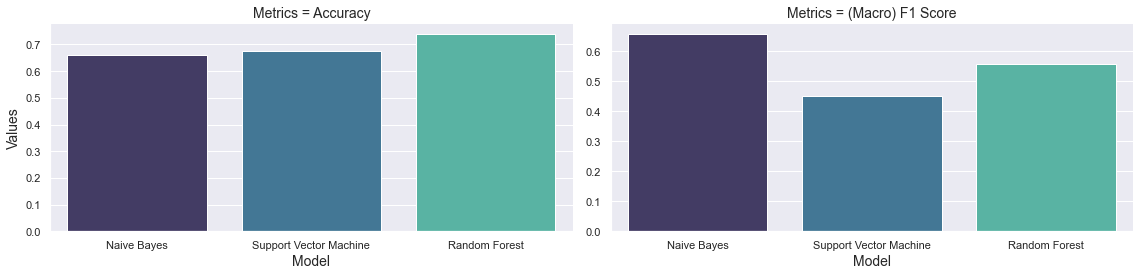

In [33]:
df_metric = pd.DataFrame({"Metrics": ["Accuracy", "(Macro) F1 Score"]* 3, 
                   "Values": [nb_acc, nb_acc, svc_acc, svc_f1, rdf_acc, rdf_f1],
                   "Model": ["Naive Bayes"] * 2 + ["Support Vector Machine"] * 2 + ["Random Forest"] * 2
                  })

df_time = pd.DataFrame({"Measurement": ["Training Time", "Inference Time"]*3,
                        "Time (s)": [nb_t_time, nb_i_time, svc_t_time, svc_i_time, rdf_t_time, rdf_i_time],
                        "Model": ["Naive Bayes"] * 2 + ["Support Vector Machine"] * 2 + ["Random Forest"] * 2
                       })

g = sns.FacetGrid(df_metric, col="Metrics", height=4, aspect=2, sharey=False)
g.map(sns.barplot, "Model", "Values", palette="mako")

plt.savefig(f"classical_metrics.pdf", format="pdf")

C:\Users\linya\anaconda3\envs\linyanIPenv\envs\linyanIPenv\envs\linyanRLenv\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


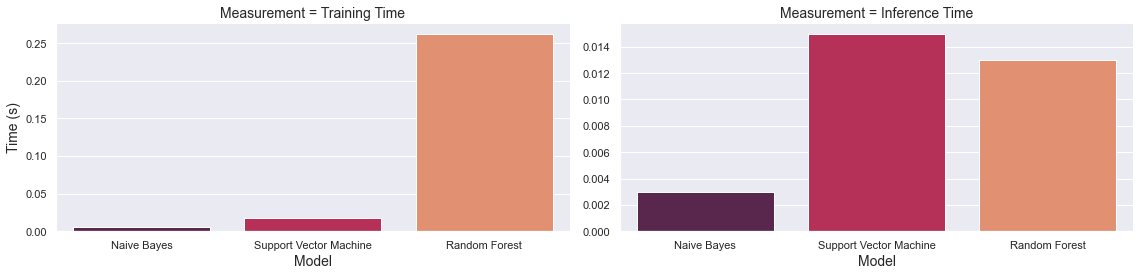

In [34]:
g = sns.FacetGrid(df_time, col="Measurement", height=4, aspect=2, sharey=False)
g.map(sns.barplot, "Model", "Time (s)", palette="rocket")

plt.savefig(f"classical_time.pdf", format="pdf")

The random forest classifier is able to archive 0.7407407407407407 accuracy!


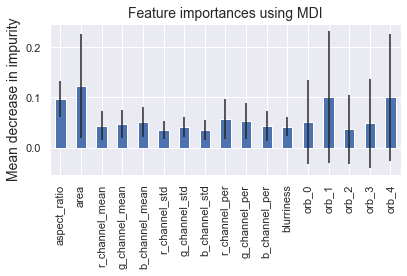

In [35]:
rdf = RandomForestClassifier()

y_pred = rdf.fit(X_train, y_train).predict(X_test)
print(f"The random forest classifier is able to archive {accuracy_score(y_test, y_pred)} accuracy!")
      
importances = rdf.feature_importances_

forest_importances = pd.Series(importances, index=X_train.columns)
importances = rdf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rdf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 2. Active Learning

In [36]:
n_repetitions = 20

In [37]:
def evaluate_random_sampling(model, x_pool, y_pool, x_test, y_test, n_queries=100, query_size=5, indices=None):
    
    # accuracy for given sample percentage
    accuracy = []
    
    # number of labeled data
    n_labels = []
    
    # initial number of labels
    n_start = 20
    
    # initialize pool of "unlabeled" data
    if indices == None: 
        indices = np.random.choice(len(x_pool), n_start, replace=False)

    # select training data from indices
    x_train = x_pool[indices]
    y_train = y_pool[indices]
    
    # update pool of available / "unlabeled" data
    x_pool = np.delete(x_pool, indices, axis = 0)
    y_pool = np.delete(y_pool, indices, axis = 0)

    model = model.fit(x_train, y_train)
    
    accuracy.append(model.score(x_test, y_test))
    n_labels.append(n_start)
    
    # iterate over number of queries
    for _ in range(n_queries):
    
        # initialize pool of "unlabeled" data
        indices = np.random.choice(len(x_pool), query_size, replace=False)

        # sample data
        x_train = np.append(x_train, x_pool[indices], axis = 0)
        y_train = np.append(y_train, y_pool[indices], axis = 0)

        # update pool of available / "unlabeled" data
        x_pool = np.delete(x_pool, indices, axis = 0)
        y_pool = np.delete(y_pool, indices, axis = 0)

        # fit model
        model = model.fit(x_train, y_train)

        accuracy.append(model.score(x_test, y_test))
        n_labels.append(n_labels[-1] +  query_size)
        
    return np.array(accuracy), np.array(n_labels)

In [38]:
# convert dataframes to numpy
x_pool_np, y_pool_np, x_test_np, y_test_np = X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy()

# set parameters for testing

n_queries = 70 # number of queries in loop
query_size = 2 # number of labels per loop iteration

random_sampling_accuracy = np.zeros(n_queries + 1)

# average results for random sampling over 20 iterations
for _ in range(n_repetitions):
        
    accuracy, n_labels = evaluate_random_sampling(RandomForestClassifier(), x_pool_np, y_pool_np,
                                                  x_test_np, y_test_np,
                                                  n_queries=n_queries, query_size = query_size)
    
    random_sampling_accuracy += accuracy / n_repetitions

In [39]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling

def evaluate_active_learning(model, sampling_method, x_pool, y_pool, x_test, y_test, n_queries=100, query_size=5):
    
    learner = ActiveLearner(estimator=model, query_strategy=sampling_method)
    
    # accuracy for given sample percentage
    accuracy = []
    
    # number of labeled data
    n_labels = []
    
    # initial number of labels
    n_start = 20
    
    # initialize pool of "unlabeled" data
    indices = np.random.choice(len(x_pool), n_start, replace=False)

    # select training data from indices
    x_train = x_pool[indices]
    y_train = y_pool[indices]
    
    # update pool of available / "unlabeled" data
    x_pool = np.delete(x_pool, indices, axis = 0)
    y_pool = np.delete(y_pool, indices, axis = 0)

    learner.teach(x_train, y_train)
    
    accuracy.append(learner.score(x_test, y_test))
    n_labels.append(n_start)
    
    # iterate over number of queries
    for _ in range(n_queries):
        
        query_idx, query_inst = learner.query(x_pool, n_instances=5)
    
        learner.teach(query_inst, y_pool[query_idx])

        x_pool, y_pool = np.delete(x_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
        
        accuracy.append(learner.score(x_test, y_test))        
        n_labels.append(n_labels[-1] +  query_size)
        
    return np.array(accuracy), np.array(n_labels)

In [40]:
margin_sampling_accuracy = np.zeros(n_queries + 1)

# average results for margin sampling over 20 iterations
for _ in range(n_repetitions):
    
    mean_accuracy, _ = evaluate_active_learning(RandomForestClassifier(), margin_sampling, 
                             x_pool_np, y_pool_np, 
                             x_test_np, y_test_np,
                             n_queries=n_queries, query_size = query_size)
    margin_sampling_accuracy += mean_accuracy / n_repetitions

In [41]:
uncertainty_sampling_accuracy = np.zeros(n_queries + 1)

# average results for margin sampling over 20 iterations
for _ in range(n_repetitions):
    
    mean_accuracy, _ = evaluate_active_learning(RandomForestClassifier(), uncertainty_sampling, 
                             x_pool_np, y_pool_np, 
                             x_test_np, y_test_np,
                             n_queries=n_queries, query_size = query_size)
    
    uncertainty_sampling_accuracy += mean_accuracy / n_repetitions

In [42]:
from modAL.uncertainty import entropy_sampling

entropy_sampling_accuracy = np.zeros(n_queries + 1)

# average results for margin sampling over 20 iterations
for _ in range(n_repetitions):
    
    mean_accuracy, _ = evaluate_active_learning(RandomForestClassifier(), entropy_sampling, 
                             x_pool_np, y_pool_np, 
                             x_test_np, y_test_np,
                             n_queries=n_queries, query_size = query_size)
    
    entropy_sampling_accuracy += mean_accuracy / n_repetitions

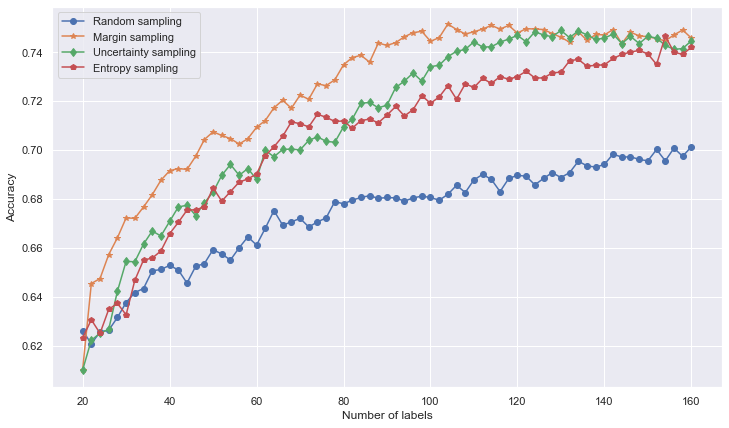

In [43]:
sns.set_theme()

fig = plt.figure(figsize=(12, 7))

plt.plot(n_labels, random_sampling_accuracy, marker='o', label="Random sampling")
plt.plot(n_labels, margin_sampling_accuracy, marker='*', label="Margin sampling")
plt.plot(n_labels, uncertainty_sampling_accuracy, marker='d', label="Uncertainty sampling")
plt.plot(n_labels, entropy_sampling_accuracy, marker='p', label="Entropy sampling")

plt.xlabel("Number of labels")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"{RandomForestClassifier().__class__.__name__}.pdf", format="pdf")

In [44]:
RandomForestClassifier().__class__.__name__

'RandomForestClassifier'